In [ ]:
!pip install tensorflow-cpu==2.12.0


INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.1 MB/s eta 0:00:00
 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras import layers, models
import os

In [ ]:
!pip show tensorflow

# Synthetic Data Generation

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import io

# Set the target dataset size
TARGET_SIZE = 5000

try:
    # --- Load the original CSV file ---
    df_original = pd.read_csv("tap_events.csv")

    print("✅ Original dataset loaded successfully.")
    print(f"Original dataset shape: {df_original.shape}")
    print(df_original.head())
    df_original.info()

    # --- Validate required columns (keep names as-is) ---
    required_cols = ['user_id', 'timestamp', 'x', 'y', 'context_screen', 'duration_ms']
    if not all(col in df_original.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_original.columns]
        raise ValueError(f"Missing required columns: {missing}")

    # Convert timestamp to datetime
    df_original['timestamp'] = pd.to_datetime(df_original['timestamp'], errors='coerce')
    df_original.dropna(subset=['timestamp'], inplace=True)

    # Get unique users
    unique_users = df_original['user_id'].unique()
    print(f"\n👤 Unique users found: {len(unique_users)} — {unique_users.tolist()}")

    # --- Check how much synthetic data is needed ---
    current_size = len(df_original)
    num_needed = TARGET_SIZE - current_size
    print(f"\n📏 Current size: {current_size}, Synthetic needed: {num_needed}")

    if num_needed <= 0:
        print("✅ Dataset already meets/exceeds target size. No synthetic data generated.")
        df_synthetic = pd.DataFrame(columns=df_original.columns)
    else:
        user_stats = {}
        for user in unique_users:
            u_df = df_original[df_original['user_id'] == user].copy()
            x_std = u_df['x'].std()
            y_std = u_df['y'].std()
            d_std = u_df['duration_ms'].std()

            user_stats[user] = {
                'x_mean': u_df['x'].mean(),
                'x_std': x_std if pd.notna(x_std) and x_std > 0 else 5,
                'y_mean': u_df['y'].mean(),
                'y_std': y_std if pd.notna(y_std) and y_std > 0 else 5,
                'context_screen_dist': u_df['context_screen'].value_counts(normalize=True).to_dict(),
                'duration_ms_values': u_df['duration_ms'].dropna().tolist(),
                'duration_ms_mean': u_df['duration_ms'].mean(),
                'duration_ms_std': d_std if pd.notna(d_std) and d_std > 0 else 10,
                'min_timestamp': u_df['timestamp'].min(),
                'max_timestamp': u_df['timestamp'].max()
            }

            if not user_stats[user]['context_screen_dist']:
                user_stats[user]['context_screen_dist'] = {'default': 1.0}

        # --- Distribute synthetic points among users ---
        base_count = num_needed // len(unique_users)
        extra = num_needed % len(unique_users)

        gen_counts = {u: base_count for u in unique_users}
        for i in range(extra):
            gen_counts[unique_users[i]] += 1

        # --- Generate synthetic data ---
        synthetic_data = []
        for user in unique_users:
            stats = user_stats[user]
            for _ in range(gen_counts[user]):
                x = np.clip(np.random.normal(stats['x_mean'], stats['x_std']), 0, 1920)
                y = np.clip(np.random.normal(stats['y_mean'], stats['y_std']), 0, 1080)

                context_screen = np.random.choice(
                    list(stats['context_screen_dist'].keys()),
                    p=list(stats['context_screen_dist'].values())
                )

                if stats['duration_ms_values']:
                    duration = np.random.choice(stats['duration_ms_values'])
                else:
                    duration = max(0, int(np.random.normal(stats['duration_ms_mean'], stats['duration_ms_std'])))

                range_sec = (stats['max_timestamp'] - stats['min_timestamp']).total_seconds()
                offset_sec = np.random.uniform(0, range_sec * 1.2 if range_sec > 0 else 86400)
                ts = stats['min_timestamp'] + timedelta(seconds=offset_sec)

                synthetic_data.append({
                    'user_id': user,
                    'timestamp': ts,
                    'x': x,
                    'y': y,
                    'duration_ms': duration,
                    'context_screen': context_screen,
                    'id': np.nan
                })

        df_synthetic = pd.DataFrame(synthetic_data)
        print(f"\n✅ Synthetic records generated: {len(df_synthetic)}")
        print(df_synthetic.head())

    # --- Combine original and synthetic datasets ---
    final_df = pd.concat([df_original, df_synthetic], ignore_index=True)
    final_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
    final_df.reset_index(drop=True, inplace=True)

    print(f"\n📊 Final combined shape: {final_df.shape}")
    print(final_df.head())

    # --- Save the final dataset to CSV ---
    final_df.to_csv("synthetic_tap_events.csv", index=False)
    print("✅ File saved as 'synthetic_tap_events.csv' with original column names.")

except ValueError as ve:
    print(f"❌ Data error: {ve}")
except Exception as e:
    print(f"❌ Unexpected error: {e}")


✅ Original dataset loaded successfully.
Original dataset shape: (314, 7)
                                user_id  id           x           y  \
0  f8e0e899-10aa-41dd-8be4-367bf324bfeb NaN  264.888889  460.444444   
1  f8e0e899-10aa-41dd-8be4-367bf324bfeb NaN  264.888889  460.444444   
2  bbc7f6a4-53e3-439f-8b99-1ca88483e321 NaN  257.000000  503.000000   
3  bbc7f6a4-53e3-439f-8b99-1ca88483e321 NaN  257.000000  503.000000   
4  f8e0e899-10aa-41dd-8be4-367bf324bfeb NaN  283.022222  433.777778   

   duration_ms                   timestamp context_screen  
0            0  2025-07-02T15:59:05.371275      dashboard  
1            0  2025-07-02T15:59:05.371275      dashboard  
2           35  2025-07-02T17:48:53.808869      pay_bills  
3           35  2025-07-02T17:48:53.808869      pay_bills  
4            0  2025-07-03T10:29:55.730579      add_funds  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 7 columns):
 #   Column          Non-Null Count 



# LOAD DATA

In [ ]:
df = pd.read_csv('synthetic_tap_events.csv')

# Handle missing values: Drop rows with missing values in essential columns, excluding 'id'
df.dropna(subset=['x', 'y', 'duration_ms', 'context_screen', 'user_id'], inplace=True)

print(f"Shape of DataFrame after dropping rows: {df.shape}")
print(f"Number of unique users after dropping rows: {df['user_id'].nunique()}")
print(f"Number of unique screens after dropping rows: {df['context_screen'].nunique()}")

Shape of DataFrame after dropping rows: (5000, 7)
Number of unique users after dropping rows: 5
Number of unique screens after dropping rows: 7


In [ ]:
df.columns

Index(['user_id', 'id', 'x', 'y', 'duration_ms', 'timestamp',
       'context_screen'],
      dtype='object')


# ENCODING + NORMALIZATION

In [ ]:
user_encoder = LabelEncoder()
screen_encoder = LabelEncoder()
df['user_id_enc'] = user_encoder.fit_transform(df['user_id'])
df['screen_enc'] = screen_encoder.fit_transform(df['context_screen'])

# Check if max values are not zero before dividing
if df['x'].max() > 0:
    df['x'] = df['x'] / df['x'].max()
if df['y'].max() > 0:
    df['y'] = df['y'] / df['y'].max()
if df['duration_ms'].max() > 0:
    df['duration_ms'] = df['duration_ms'] / df['duration_ms'].max()



# DUPLICATE IF TOO SMALL (TESTING PURPOSE)
if len(df) < 20 and len(df) > 0: # Only duplicate if df is not empty and small
    print(f"Duplicating data from {len(df)} rows for testing purposes.")
    df = pd.concat([df] * 5, ignore_index=True)
    print(f"Shape of DataFrame after duplication: {df.shape}")

In [ ]:
screen_encoding_map = {screen: idx for idx, screen in enumerate(screen_encoder.classes_)}
print("📋 Screen Encoding Map:")
for screen, code in screen_encoding_map.items():
    print(f"'{screen}' → {code}")


📋 Screen Encoding Map:
'RegisterPage' → 0
'add_funds' → 1
'dashboard' → 2
'pay_bills' → 3
'profile' → 4
'statements' → 5
'transfer_page' → 6




# FINAL FEATURES & LABELS

In [ ]:
# Group by sessions (simplified: group by user & screen)
sessions = df.groupby(['user_id_enc', 'context_screen']).agg({
    'x': 'mean',
    'y': 'mean',
    'duration_ms': 'mean',
    'screen_enc': 'first'
}).reset_index()

# Print the shape of the sessions DataFrame after grouping
print(f"Shape of sessions DataFrame after grouping: {sessions.shape}")


features = sessions[['x', 'y', 'duration_ms', 'screen_enc']].values
labels = sessions['user_id_enc'].values

# Print the shapes of features and labels
print(f"Shape of features array: {features.shape}")
print(f"Shape of labels array: {labels.shape}")

Shape of sessions DataFrame after grouping: (17, 6)
Shape of features array: (17, 4)
Shape of labels array: (17,)





# HEATMAP

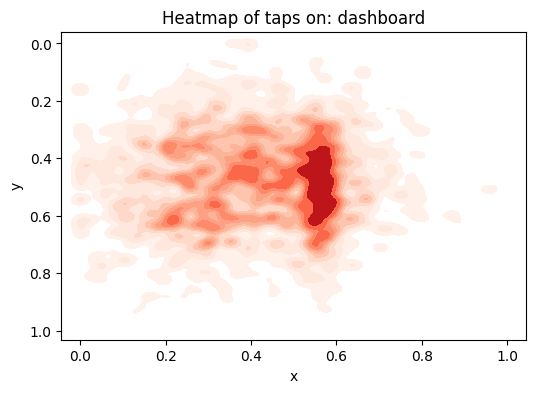

In [ ]:
screen_to_plot = 'dashboard'
# Check if the screen exists in the data before plotting
if screen_to_plot in df['context_screen'].unique():
    df_screen = df[df['context_screen'] == screen_to_plot]
    plt.figure(figsize=(6, 4))
    sns.kdeplot(x=df_screen['x'], y=df_screen['y'], fill=True, cmap="Reds", bw_adjust=0.3) # Use fill instead of shade
    plt.title(f'Heatmap of taps on: {screen_to_plot}')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print(f"Screen '{screen_to_plot}' not found in the data.")

# PAIR CREATION

In [ ]:
def create_pairs(features, labels):
    pair_features, pair_labels = [], []
    n = len(features)
    if n < 2:
        print("Not enough features to create pairs.")
        return np.array(pair_features), np.array(pair_labels)

    for i in range(n):
        for j in range(i + 1, n):
            pair_features.append([features[i], features[j]])
            pair_labels.append(1 if labels[i] == labels[j] else 0)

    return np.array(pair_features), np.array(pair_labels)


X_pairs, y_pairs = create_pairs(features, labels)

# Check if there are enough pairs to split and train
if len(X_pairs) < 10:
    raise ValueError("Not enough data for training. Please ensure your CSV has enough valid tap events to create at least 10 pairs.")



# TRAIN/TEST SPLIT

In [ ]:
X1 = np.array([x[0] for x in X_pairs])
X2 = np.array([x[1] for x in X_pairs])
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y_pairs, test_size=0.2, random_state=42, stratify=y_pairs if len(np.unique(y_pairs)) > 1 else None)


# BUILD BASE MODEL
def build_base_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(input)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    return models.Model(input, x)

input_shape = X1_train.shape[1:]
base_network = build_base_network(input_shape)

input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = layers.Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
output = layers.Dense(1, activation='sigmoid')(distance)
siamese_net = models.Model([input_a, input_b], output)
siamese_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# TRAIN and EXPORT

In [ ]:
siamese_net.fit([X1_train, X2_train], y_train, validation_data=([X1_test, X2_test], y_test), epochs=100, batch_size=32)
loss, acc = siamese_net.evaluate([X1_test, X2_test], y_test)
print(f"Test Accuracy: {acc:.4f}")

# EXPORT MODEL
export_dir = "siamese_model.keras"
base_network.save(export_dir)
print(f"Base feature extractor saved at: {export_dir}")


Epoch 1/100
4/4 [==============================] - 1s 66ms/step - loss: 0.6890 - accuracy: 0.4722 - val_loss: 0.6652 - val_accuracy: 0.6786
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6252 - accuracy: 0.7593 - val_loss: 0.6511 - val_accuracy: 0.7500
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5988 - accuracy: 0.7685 - val_loss: 0.6526 - val_accuracy: 0.7500
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5887 - accuracy: 0.7685 - val_loss: 0.6563 - val_accuracy: 0.7857
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5871 - accuracy: 0.7685 - val_loss: 0.6562 - val_accuracy: 0.7857
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.5859 - accuracy: 0.7685 - val_loss: 0.6555 - val_accuracy: 0.7857
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.5849 - accuracy: 0.7685 - val_loss: 0.6519 - val_accuracy: 0.7857
Epoch 8/100
4/4 [=======

Test Accuracy: 0.9643
Base feature extractor saved at: siamese_model.keras



# ONE-SHOT PREDICTION

In [ ]:
def one_shot_predict(query_sample, support_set, support_labels, base_model):
    query_embedding = base_model.predict(np.array([query_sample]))
    support_embeddings = base_model.predict(np.array(support_set))
    distances = np.linalg.norm(support_embeddings - query_embedding, axis=1)
    min_index = np.argmin(distances)
    return support_labels[min_index], distances[min_index]

# EXAMPLE PREDICTION
if len(features) > 1 and len(labels) > 1:
    query_idx = 0
    support_indices = list(range(1, min(len(features), 6))) # Use min to avoid index out of bounds
    if len(support_indices) > 0:
        pred_label, pred_distance = one_shot_predict(features[query_idx], features[support_indices], labels[support_indices], base_network)
        print(f"🔍 One-shot predicted label: {pred_label}, True: {labels[query_idx]}, Distance: {pred_distance:.4f}")
    else:
        print("Not enough samples to perform one-shot prediction.")
else:
    print("Not enough features or labels to perform one-shot prediction.")


1/1 [==============================] - 0s 25ms/step
🔍 One-shot predicted label: 0, True: 0, Distance: 1.1681


# save model as tflite

In [ ]:
model = tf.keras.models.load_model('siamese_model.keras')

# Create the converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) Enable optimizations for smaller size and better latency
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
with open('siamese_model_new.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ TFLite model saved as 'siamese_model.tflite'")

✅ TFLite model saved as 'siamese_model.tflite'
